## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [1]:
import os
import pandas as pd
import numpy as np
data_dir = './data'
images_dir = os.path.join(data_dir,'images')
gt_file = os.path.join(data_dir, 'gt.csv')

In [2]:
from keras_tqdm import TQDMNotebookCallback
from keras import backend as K

Using TensorFlow backend.


In [3]:
### Useful routines for preparing data
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize

eye_left = [0,1,2,3,8,9,10,11,12,13]
eye_right = [4,5,6,7,14,15,16,17,18,19]
nose = [20, 21]
mouth_left = [22,23]
mouth_center = [24,25]
mouth_right = [26, 27]
points_order = np.array(eye_left + eye_right + nose + mouth_left + mouth_center + mouth_right)
flip_order = np.array(eye_right + eye_left + nose + mouth_right + mouth_center + mouth_left)

def load_imgs_and_keypoints(dirname='./data'):
    # Write your code for loading images and points here
    img_size = 100
    points = pd.read_csv(join(dirname,'gt.csv')).values
    points = points[ :, 1:]
    images_dir = join(dirname,'images')
    img_files = [join(images_dir,f) for f in  sorted(os.listdir(images_dir))]
    #print(len(img_files))
    imgs = []
    img_scale = []
    for i, file in enumerate(img_files):
        img = imread(file)
        h, w = np.array(img.shape[ : 2])
        if len(img.shape) == 2:
            img = gray2rgb(img)
        #img_scale.append(14*img.shape[ :2])
        # resize image
        img = resize(img, (img_size, img_size, 3))
        imgs.append(img)
        points[i][ : : 2] = points[i][ : : 2]/h
        points[i][1 : :2] = points[i][1 : : 2]/w
    #img_scale = array(img_scale)
    #points = points/img_scale
    points = points - 0.5
    return array(imgs), points
    
    


imgs, points = load_imgs_and_keypoints()

/home/david/anaconda2/envs/py3k/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/david/anaconda2/envs/py3k/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

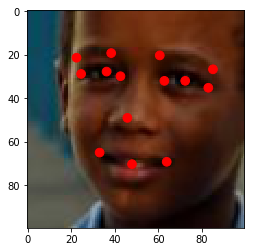

In [4]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points, color='red'):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    points = 100*(points + 0.5)
    for i in range(14):
        circ = Circle((points[2*i], points[2*i+1]), 2, color=color)
        ax.add_patch(circ)
    plt.show()
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [5]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1, random_state=1234)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

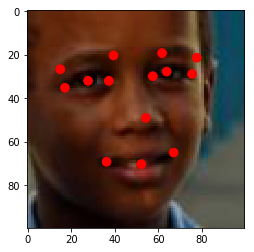

In [6]:
def flip_img(img, points):
    # Write your code for flipping here
    num_points = int(len(points)/2)
    fp = np.reshape(points,(num_points,2))*np.array([-1,1])
    fp = np.squeeze(np.reshape(fp, (2*num_points,1)))
    #fp = fp[flip_order]
    #fp = points[flip_order]
    fl_img = img[ :, : :-1]
    flip_order = np.array([6, 7, 4, 5, 2, 3, 0, 1, 18, 19, 16, 17, 14, 15,
                 12, 13, 10, 11, 8, 9, 20, 21, 26, 27, 24, 25, 22, 23])
    return fl_img, fp[flip_order]
f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

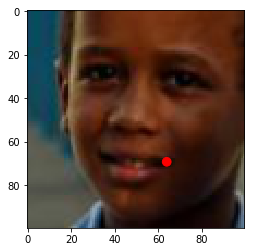

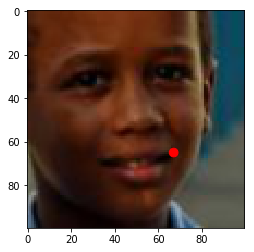

In [8]:
pt = f_points.copy()
fimg = f_img
img1 = imgs[1]
slice0 = np.arange(4, 6)
pts0 = points[1].copy()

k = 26
slice2 =np.arange(k,k+2)
pts0[[x for x in  np.arange(28) if x not in slice2]] =-888
visualize_points(img1, pts0)
slice1 = np.arange(22,24)
pt[[x for x in  np.arange(28) if x not in slice2]] =-888

visualize_points(f_img,pt)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [9]:
# Write your code here

def get_aug_train(imgs, points):
    aug_imgs = []
    aug_pts = []
    
    for img, pts in zip(imgs, points):
        aug_imgs.append(img)
        aug_pts.append(pts[points_order])
        flp_img, flip_pts = flip_img(img, pts)
        aug_imgs.append(flp_img)
        aug_pts.append(flip_pts)
    return np.array(aug_imgs), np.array(aug_pts)
        

In [10]:
aug_imgs_train, aug_points_train = get_aug_train(imgs_train, points_train)

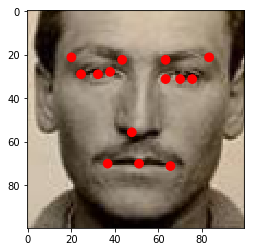

In [14]:
i= 2*np.random.randint(0,aug_imgs_train.shape[0]/2)
visualize_points(aug_imgs_train[i], aug_points_train[i])

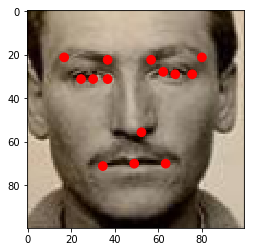

In [15]:
visualize_points(aug_imgs_train[i+1], aug_points_train[i+1])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [16]:
K.clear_session()
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)
KERNEL = [3, 3]
DROPOUT=0.25
model1 = Sequential()
# Define here your model
model1.add(Conv2D(filters=256,
                 input_shape=(100, 100, 3),
                 kernel_size=KERNEL,
                 padding='same',
                 strides=(1,1),
                 activation='relu',
                 name='conv1'))
#model1.add(Dropout(DROPOUT))
model1.add(MaxPooling2D(name='max_pool_1'))


model1.add(Conv2D(filters=128,
                 kernel_size=KERNEL,
                 padding='same',
                 strides=(1,1),
                 activation='relu',
                 name='conv2'))
#model1.add(Dropout(DROPOUT))
model1.add(MaxPooling2D(name='max_pool_2'))


model1.add(Conv2D(filters=128,
                 kernel_size=KERNEL,
                 padding='same',
                 strides=(1,1),
                 activation='relu',
                 name='conv3'))
model1.add(MaxPooling2D(name='max_pool_3'))


model1.add(Conv2D(filters=32,
                 kernel_size=KERNEL,
                 padding='same',
                 strides=(1,1),
                 activation='relu',
                 name='conv4'))
model1.add(MaxPooling2D(name='max_pool_4'))

model1.add(Flatten(name='flatten'))

model1.add(Dense(units=1024, activation='relu', name='dense1'))
#model1.add(Dropout(DROPOUT))
model1.add(Dense(units=1024, activation='relu', name='dense2'))
#model1.add(Dropout(DROPOUT))
model1.add(Dense(units=64, activation='relu', name='dense3'))
#model1.add(Dropout(rate=0.10))
model1.add(Dense(units=28, name='output'))



In [ ]:
K.clear_session()
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)
KERNEL = [3, 3]
DROPOUT=0.25
model2 = Sequential()
# Define here your model
model2.add(Conv2D(filters=16,
                 input_shape=(100, 100, 3),
                 kernel_size=KERNEL,
                 padding='same',
                 strides=(1,1),
                 activation='relu',
                 name='conv1'))

model2.add(Conv2D(filters=32,
                 kernel_size=KERNEL,
                 padding='same',
                 strides=(1,1),
                 activation='relu',
                 name='conv1a'))

model2.add(Conv2D(filters=32,
                 kernel_size=KERNEL,
                 padding='same',
                 strides=(1,1),
                 activation='relu',
                 name='conv1b'))
#model2.add(Dropout(DROPOUT))
#model2.add(Dropout(DROPOUT))
model2.add(MaxPooling2D(name='max_pool_1'))


model2.add(Conv2D(filters=64,
                 kernel_size=KERNEL,
                 padding='same',
                 strides=(1,1),
                 activation='relu',
                 name='conv2'))
#model2.add(Dropout(DROPOUT))
model2.add(MaxPooling2D(name='max_pool_2'))


model2.add(Conv2D(filters=128,
                 kernel_size=KERNEL,
                 padding='same',
                 strides=(1,1),
                 activation='relu',
                 name='conv3'))
model2.add(MaxPooling2D(name='max_pool_3'))

model2.add(Conv2D(filters=128,
                 kernel_size=KERNEL,
                 padding='same',
                 strides=(1,1),
                 activation='relu',
                 name='conv4'))
model2.add(MaxPooling2D(name='max_pool_4'))


model2.add(Flatten(name='flatten'))

model2.add(Dense(units=512, activation='relu', name='dense1'))
#model2.add(Dropout(0.5))
model2.add(Dense(units=128, activation='relu', name='dense2'))
#model2.add(Dropout(0.25))
#model2.add(Dense(units=64, activation='relu', name='dense3'))
#model2.add(Dropout(rate=0.10))
model2.add(Dense(units=28, name='output'))



In [88]:
K.clear_session()
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)
KERNEL = [3, 3]
DROPOUT=0.25
model1 = Sequential()
# Define here your model
model1.add(Conv2D(filters=16,
                 input_shape=(100, 100, 3),
                 kernel_size=KERNEL,
                 padding='same',
                 strides=(1,1),
                 activation='relu',
                 name='conv1'))
#model1.add(Dropout(DROPOUT))
model1.add(MaxPooling2D(name='max_pool_1'))


model1.add(Conv2D(filters=32,
                 kernel_size=KERNEL,
                 padding='same',
                 strides=(1,1),
                 activation='relu',
                 name='conv2'))
#model1.add(Dropout(DROPOUT))
model1.add(MaxPooling2D(name='max_pool_2'))


model1.add(Conv2D(filters=64,
                 kernel_size=KERNEL,
                 padding='same',
                 strides=(1,1),
                 activation='relu',
                 name='conv3'))
model1.add(MaxPooling2D(name='max_pool_3'))



#model1.add(Conv2D(filters=128,
#                 kernel_size=KERNEL,
#                 padding='same',
#                 strides=(1,1),
#                 activation='relu',
#                 name='conv5'))
#model1.add(MaxPooling2D(name='max_pool_5'))

model1.add(Flatten(name='flatten'))

model1.add(Dense(units=32, activation='relu', name='dense1'))
#model1.add(Dropout(0.5))
model1.add(Dense(units=32, activation='relu', name='dense2'))
model1.add(Dropout(0.5))
#model1.add(Dense(units=64, activation='relu', name='dense3'))
#model1.add(Dropout(rate=0.10))
model1.add(Dense(units=28, name='output'))



In [17]:
#K.clear_session()
model = model1
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 100, 100, 256)     7168      
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 50, 50, 256)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 50, 50, 128)       295040    
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 25, 25, 128)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 25, 25, 128)       147584    
_________________________________________________________________
max_pool_3 (MaxPooling2D)    (None, 12, 12, 128)       0         
_________________________________________________________________
conv4 (Conv2D)               (None, 12, 12, 32)        36896     
__________

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [19]:
#load weights
os.listdir('./weights')


['.ipynb_checkpoints']

In [20]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.optimizers import SGD, Adam
from time import time

checkpointer = ModelCheckpoint(filepath='./weights/model1_weights.{epoch:02d}-{val_loss:.5f}.hdf5', verbose=0, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='min')
tensorboard = TensorBoard(log_dir='./logs/logs.{}'.format(time()))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.001)
# Choose optimizer, compile model and run training
model.compile(optimizer=adam, loss='mse')


In [21]:
history_callback = model.fit(imgs_train, points_train,
         batch_size=32,
         epochs=20,
         validation_data=(imgs_val,points_val),
         verbose=2,
         callbacks=[checkpointer, earlyStopping, tensorboard, TQDMNotebookCallback(leave_inner=False, leave_outer=False)])


Train on 5400 samples, validate on 600 samples


Epoch 1/20


 - 39s - loss: 0.0045 - val_loss: 0.0028
Epoch 2/20


 - 47s - loss: 0.0031 - val_loss: 0.0028
Epoch 3/20


 - 46s - loss: 0.0030 - val_loss: 0.0023
Epoch 4/20


 - 46s - loss: 0.0021 - val_loss: 0.0018
Epoch 5/20


 - 46s - loss: 0.0017 - val_loss: 0.0015
Epoch 6/20


 - 46s - loss: 0.0015 - val_loss: 0.0014
Epoch 7/20


 - 46s - loss: 0.0013 - val_loss: 0.0012
Epoch 8/20


 - 45s - loss: 0.0012 - val_loss: 0.0012
Epoch 9/20


 - 45s - loss: 0.0011 - val_loss: 0.0010
Epoch 10/20


 - 46s - loss: 9.1833e-04 - val_loss: 9.2318e-04
Epoch 11/20


 - 45s - loss: 7.7297e-04 - val_loss: 9.2963e-04
Epoch 12/20


 - 45s - loss: 6.9322e-04 - val_loss: 8.7746e-04
Epoch 13/20


 - 47s - loss: 6.3157e-04 - val_loss: 7.5474e-04
Epoch 14/20


 - 45s - loss: 5.9113e-04 - val_loss: 7.4793e-04
Epoch 15/20


 - 44s - loss: 5.4096e-04 - val_loss: 7.2640e-04
Epoch 16/20


 - 44s - loss: 5.0273e-04 - val_loss: 6.6808e-04
Epoch 17/20


 - 44s - loss: 4.9937e-04 - val_loss: 7.1432e-04
Epoch 18/20


 - 44s - loss: 4.6634e-04 - val_loss: 6.4701e-04
Epoch 19/20


 - 44s - loss: 4.5166e-04 - val_loss: 7.5413e-04
Epoch 20/20


 - 44s - loss: 4.2886e-04 - val_loss: 6.3310e-04


In [22]:
train_loss = history_callback.history['loss']
val_loss = history_callback.history['val_loss']

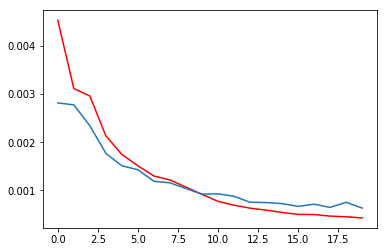

In [23]:
plt.plot(list(range(len(train_loss))), np.array(train_loss), color='red')
plt.plot(list(range(len(val_loss))), np.array(val_loss))
plt.show()

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [24]:
def visualize_img_list(imgs, points, pred_points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    N = len(imgs)
    #fig = plt.figure()
    for n in range(N):
        fig = plt.figure()
        a = fig.add_subplot(1, 2, 1)
        plt.imshow(imgs[n])
        pts = 100*(points[n] + 0.5)
        for i in range(14):
            circ = Circle((pts[2*i], pts[2*i+1]), 2, color='red')
            a.add_patch(circ)
            a.set_title('target')
        b = fig.add_subplot(1, 2, 2)
        plt.imshow(imgs[n])
        pts = 100*(pred_points[n] + 0.5)
        for i in range(14):
            circ = Circle((pts[2*i], pts[2*i+1]), 2, color='blue')
            b.add_patch(circ)
            b.set_title('predicted')
    plt.show()


In [31]:
## take random sample of images and points from val set
import random 

idx = random.sample(range(len(imgs_val)), 10)
sample_val_imgs = imgs_val[idx]
sample_val_points = points_val[idx]


pred_val_points = model.predict(sample_val_imgs)


In [26]:
os.listdir('./weights')

['model1_weights.16-0.00067.hdf5',
 '.ipynb_checkpoints',
 'model1_weights.20-0.00063.hdf5',
 'model1_weights.04-0.00177.hdf5',
 'model1_weights.05-0.00151.hdf5',
 'model1_weights.03-0.00234.hdf5',
 'model1_weights.01-0.00282.hdf5',
 'model1_weights.02-0.00278.hdf5',
 'model1_weights.14-0.00075.hdf5',
 'model1_weights.12-0.00088.hdf5',
 'model1_weights.09-0.00104.hdf5',
 'model1_weights.10-0.00092.hdf5',
 'model1_weights.08-0.00116.hdf5',
 'model1_weights.07-0.00119.hdf5',
 'model1_weights.06-0.00143.hdf5',
 'model1_weights.18-0.00065.hdf5',
 'model1_weights.15-0.00073.hdf5',
 'model1_weights.13-0.00075.hdf5']

In [27]:
model.load_weights('./weights/model1_weights.18-0.00065.hdf5')

In [28]:
print('\n val error: {}'.format(model.evaluate(imgs_val ,points_val, batch_size=32)))

600/600 [==============================] - 1s 984us/step

 val error: 0.0006470124345893661


In [29]:
print('\n train error: {}'.format(model.evaluate(imgs_train, points_train, batch_size=32)))

5400/5400 [==============================] - 8s 1ms/step

 train error: 0.00043834260294075915


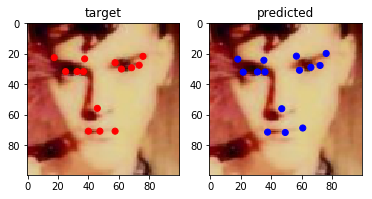

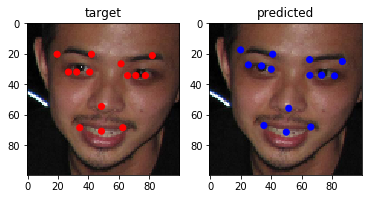

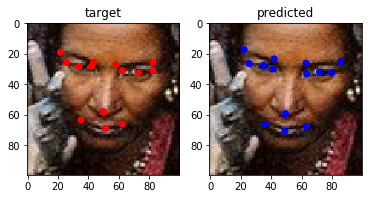

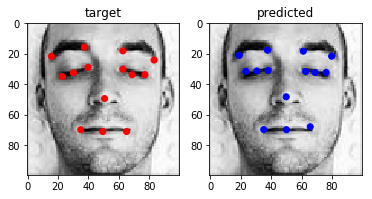

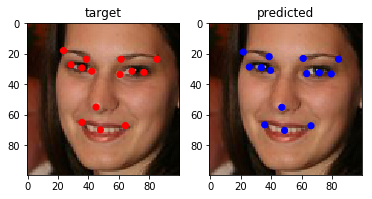

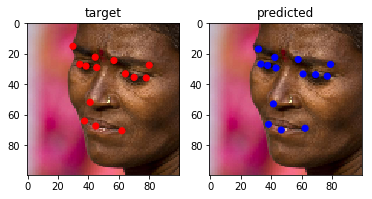

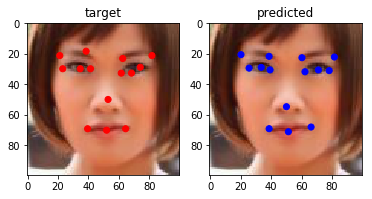

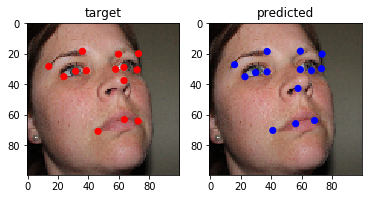

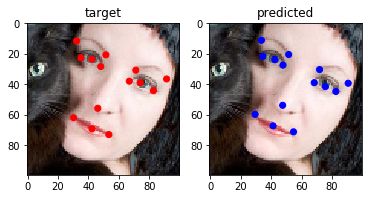

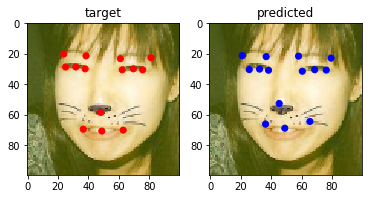

In [32]:
visualize_img_list(sample_val_imgs, sample_val_points, pred_val_points)